# **Fine-Tuning an OCR Model for Handwriting Recognition**

-------------------------------------------
### ⚠️ Important: GPU Setup for NVIDIA DGX A100

**Run this block of code before installing any libraries or executing your code** to properly configure the NVIDIA DGX A100 and specify which GPU to use.


In [1]:
import os
# Only allow GPU 0,1,2,3 (exclude GPU 4, which is the DGX Display)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"


In [2]:
import torch
print(torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


4
GPU 0: NVIDIA A100-SXM4-40GB
GPU 1: NVIDIA A100-SXM4-40GB
GPU 2: NVIDIA A100-SXM4-40GB
GPU 3: NVIDIA A100-SXM4-40GB


In [3]:
!nvidia-smi

Fri May 16 09:20:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:01:00.0 Off |                    0 |
| N/A   40C    P0             55W /  275W |      18MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

----------------------------------------------------------------

### Data Preparation

## Dataset Selection and Structure

### 1. Dataset Chosen

The **IAM Handwriting Database** was selected for this project. It contains a total of **13,353 handwritten English text lines** written by **657 different writers**.

- **Access**: [IAM Handwriting Database](https://fki.tic.heia-fr.ch/DBs/iamDB/data/)  
  > _Note: VPN was used to access the website due to regional restrictions._

---

### 2. Focus Area

The focus of this project is on **line-level annotations**. Therefore, only the relevant parts of the dataset (line images and corresponding annotations) were extracted and used.

---

### 3. Original Dataset Structure

After downloading, the IAM dataset has the following directory structure:
```
Data/
├── ascii
├── formsA-D
├── formsE-H
├── formsI-Z
├── lines
├── sentences
├── words
└── xml
```


- `ascii/`: Contains text annotation files.
- `formsA-D`, `formsE-H`, `formsI-Z`: Contain scanned handwritten form images.
- `lines/`: Contains cropped line-level images.
- `sentences/`, `words/`: Contain sentence-level and word-level images.
- `xml/`: Contains XML metadata.

---

### 4. Refined Dataset Structure

For the line-level task, only two essential components were retained: line images and their annotations. The refined dataset structure looks like:
<!-- |- Data
   |- lines
      |- a01
          |- a01-107
          |- ...
          |- a01-020x
      |- ...
      |- a02
      |- a03
      |- r06
   |- ascii
      |- lines.txt -->
```
Data/
├── lines/
│ ├── a01/
│ │ ├── a01-000u.png
│ │ ├── a01-007.png
│ │ ├── ...
│ │ └── a01-020x.png
│ ├── a02/
│ ├── a03/
│ └── r06/
└── ascii/
└── lines.txt
```


This below code is designed to arrange the dataset into the desired folder structure and create a CSV file containing the paths to images along with their corresponding text labels.

The output structure will look as follows:

```
IAM_Data/
├── images/
│ ├── a01-000u.png
│ ├── a01-007.png
│ ├── ...
│ └── a01-020x.png
├── Actual_Labels.csv
```


In [ ]:
import os
import shutil
import pandas as pd

# Path to the base directory where the images and text files are located
base_dir = 'data/lines/'  # Directory containing the images
lines_txt_path = 'data/ascii/lines.txt'  # Path to the lines.txt file


# Define the output directory structure
output_dir = 'IAM_Data'
images_dir = os.path.join(output_dir, 'images')
labels_file = os.path.join(output_dir, 'labels.csv')

# Create the IAM_Data folder and images folder
os.makedirs(images_dir, exist_ok=True)

# List to store data for CSV file
image_paths = []
texts = []

# Open the lines.txt file and read the content
with open(lines_txt_path, 'r') as file:
    for line in file:
        # Ignore comment lines
        if line.startswith("#"):
            continue

        # Split line by space and extract the necessary information
        parts = line.split()
        image_id = parts[0]  # image id (e.g., a01-000u-00)
        segmentation_result = parts[1]  # "ok" or "err"

        # Only process lines where segmentation result is "ok"
        if segmentation_result != "ok":
            continue

        bounding_box = parts[2:6]  # Bounding box (not used for this task)
        text = " ".join(parts[6:]).replace("|", " ")  # Transcription text     # Slicing should be done carefull by properly checking from which col the actual transcription starts.

        # Search for the corresponding PNG image file in the subdirectories
        for root, dirs, files in os.walk(base_dir):
            for file_name in files:
                if file_name.startswith(image_id) and file_name.endswith('.png'):
                    image_path = os.path.join(root, file_name)

                    # Move the image to the new folder
                    shutil.copy(image_path, os.path.join(images_dir, file_name))

                    # Append the data to the lists for the CSV
                    image_paths.append(os.path.join('images', file_name))
                    texts.append(text)
                    break

# Create a DataFrame and save to labels.csv
df = pd.DataFrame({'image_path': image_paths, 'text': texts})
df.to_csv(labels_file, index=False)

print("Process completed successfully!")


In [ ]:
import pandas as pd
import re

# Load your CSV
df = pd.read_csv("IAM_Data/labels.csv")  # Replace with your actual file name

# Remove leading numbers using regex
df['text'] = df['text'].str.replace(r'^\d+\s+\d+\s+', '', regex=True)

# Save the cleaned data if needed
df.to_csv("IAM_Data/Actual_Labels.csv", index=False)


The final dataset structure for the IAM dataset, which will be fed into the network, is organized as follows:

```
IAM_Data/
├── images/
│ ├── a01-000u.png
│ ├── a01-007.png
│ ├── ...
│ └── a01-020x.png
├── Actual_Labels.csv
```

- **`images/`**: Contains all the line-level image files, each representing a handwritten line of text.
- **`Actual_Labels.csv`**: This file contains the annotations for each image, including the corresponding transcriptions for each handwritten line.

This structure ensures a clean and efficient organization, simplifying the process of associating image files with their respective labels for easier data processing.




### Drive Mount

In [ ]:
# Mount the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Unzipping Dataset from Drive

In [ ]:
import zipfile
import os

def unzip_folder(zip_file_path, output_location):
    # Check if the output location exists, create it if not
    if not os.path.exists(output_location):
        os.makedirs(output_location)

    # Unzipping the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_location)
        print(f"Unzipped files to {output_location}")

# Example usage
zip_file_path = '/content/drive/MyDrive/INFUTRIX/IAM_Data.zip'  # Replace with your zip file path
output_location = '/content/drive/MyDrive/INFUTRIX/IAM_Data/'  # Replace with your desired output location

unzip_folder(zip_file_path, output_location)


Unzipped files to /content/drive/MyDrive/INFUTRIX/IAMData/


In [4]:
# Counting the number of Images in the Folder "images"
import glob
import os

folder_path = 'IAM_Data/images'
image_count = len(glob.glob(os.path.join(folder_path, '*.[jpgnPNG]*')))
print(f"Number of images: {image_count}")


Number of images: 11344


In [5]:
# Checking how many lables present in labels.csv
import pandas as pd
df = pd.read_csv('IAM_Data/Actual_Labels.csv')
print(df.shape)
df.head()

(11344, 2)


,image_path,text
0,images/a01-000u-00.png,A MOVE to stop Mr. Gaitskell from
1,images/a01-000u-01.png,nominating any more Labour life Peers
2,images/a01-000u-02.png,is to be made at a meeting of Labour
3,images/a01-000u-04.png,put down a resolution on the subject
4,images/a01-000u-06.png,"Griffiths , M P for Manchester Exchange ."


**Segmentation Result Validation**

After proceeding with the above code and validating the segmentation results, we checked the annotation file `lines.txt`. Only the files where the `segmentation result is marked as "OK"` are selected. Initially, we had 13,353 files, but after filtering based on the "OK" status in `lines.txt`, we are left with 11,344 files whose statistics are acceptable.

We will now proceed with this subset of 11,344 files for further analysis.


**Visualizing a few images along with their corresponding annotated text.**


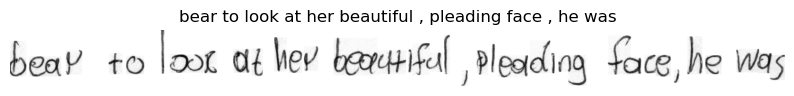

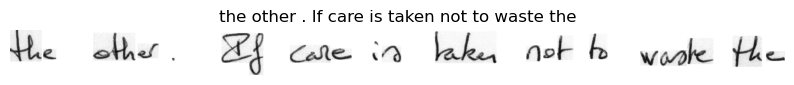

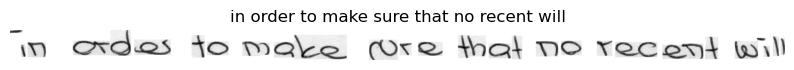

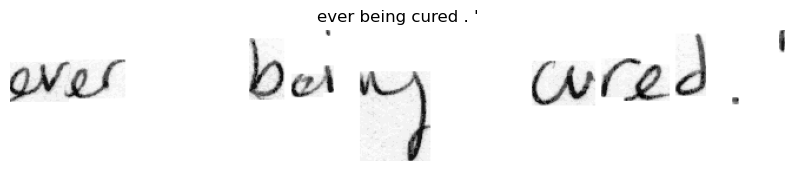

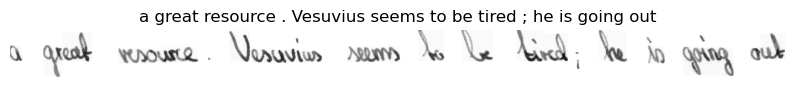

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Path to the labels CSV
csv_path = 'IAM_Data/Actual_Labels.csv'

# Load the CSV
df = pd.read_csv(csv_path)

# Fix any backslashes
df['image_path'] = df['image_path'].apply(lambda x: x.replace('\\', '/'))

# Base directory where the images are stored (full Google Drive path)
base_image_dir = 'IAM_Data/'

# Randomly select 5 rows
sampled_df = df.sample(n=5).reset_index(drop=True)

# Loop through the selected samples
for idx, row in sampled_df.iterrows():
    img_path = os.path.normpath(os.path.join(base_image_dir, row['image_path']))
    # print(f"Loading image from: {img_path}")

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to read image: {img_path}")
        continue

    plt.figure(figsize=(10, 2))
    plt.imshow(img, cmap='gray')
    plt.title(row['text'], fontsize=12)
    plt.axis('off')
    plt.show()


# 📄 Image Preprocessing and Denoising Techniques

Let's try some image processing techniques to understand which methods can be used for denoising.

📚  **Libraries Used**
```
python
import cv2
import numpy as np
import matplotlib.pyplot as plt
```

⚙️ **Techniques Implemented**
```
- CLAHE (Contrast Limited Adaptive Histogram Equalization)
- Color Constancy
- Gaussian Denoising
- Sharpening
- Histogram Equalization
- Hybrid Approaches

```

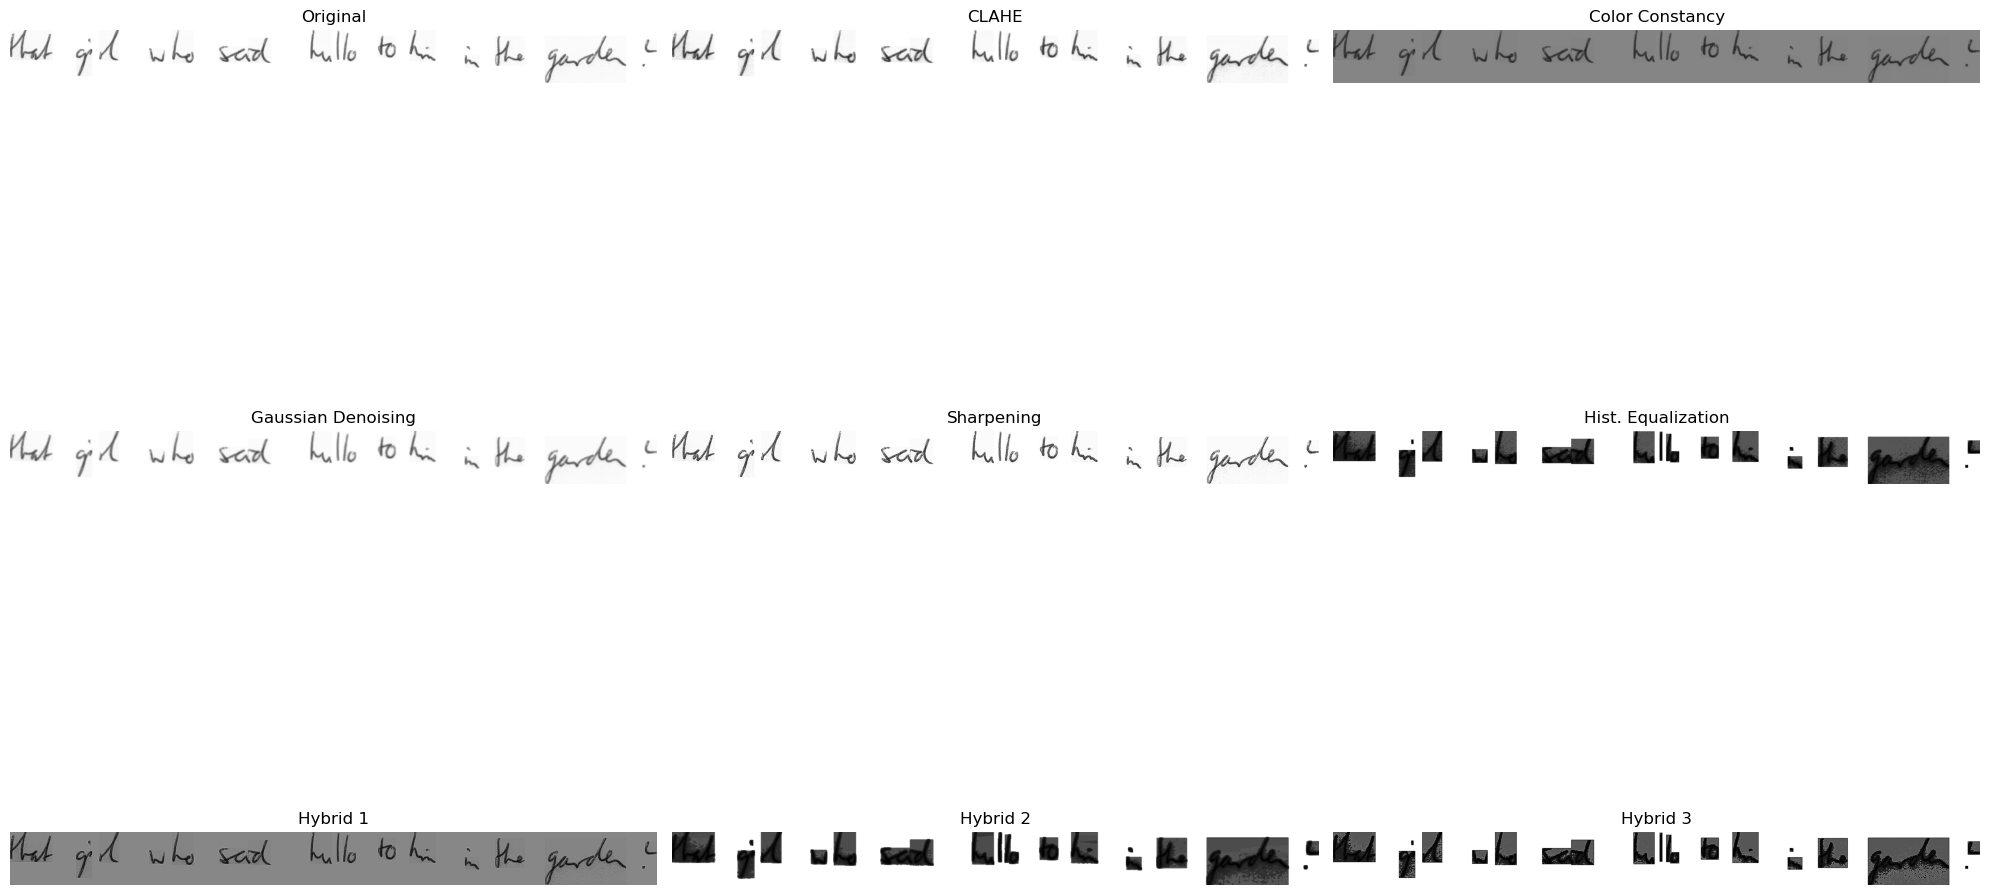

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =================== Preprocessing Techniques ===================
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_color_constancy(image):
    result = image.astype(np.float32)
    result = result / (np.mean(result, axis=(0, 1)) + 1e-8)
    result = np.clip(result * 128, 0, 255).astype(np.uint8)
    return result

def apply_gaussian_denoising(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_sharpening(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def apply_histogram_equalization(image):
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
    return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)

# ======================== Hybrid Techniques ========================
def hybrid1(image):  # CLAHE → Color Constancy → Sharpening
    image = apply_clahe(image)
    image = apply_color_constancy(image)
    return apply_sharpening(image)

def hybrid2(image):  # Denoising → CLAHE → Histogram Equalization
    image = apply_gaussian_denoising(image)
    image = apply_clahe(image)
    return apply_histogram_equalization(image)

def hybrid3(image):  # Color Constancy → HistEq → Sharpening
    image = apply_color_constancy(image)
    image = apply_histogram_equalization(image)
    return apply_sharpening(image)

# =================== Display All Variants ===================
def visualize_processing(image_path):
    # Read original image
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Processed variants
    variants = {
        "Original": img_rgb,
        "CLAHE": apply_clahe(img_rgb),
        "Color Constancy": apply_color_constancy(img_rgb),
        "Gaussian Denoising": apply_gaussian_denoising(img_rgb),
        "Sharpening": apply_sharpening(img_rgb),
        "Hist. Equalization": apply_histogram_equalization(img_rgb),
        "Hybrid 1": hybrid1(img_rgb),
        "Hybrid 2": hybrid2(img_rgb),
        "Hybrid 3": hybrid3(img_rgb),
    }

    # Plotting
    plt.figure(figsize=(20, 15))
    for i, (title, img) in enumerate(variants.items()):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
# Provide full path to image
image_path = 'IAM_Data/images/r06-143-04.png'  # replace with your image
visualize_processing(image_path)


# 📄 Fast Non-Local Means Denoising

In addition to the previous preprocessing techniques, I have also implemented the **Fast Non-Local Means Denoising** method, which is highly effective for removing noise while preserving fine details in the image.

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def compare_fastnlmeans(image_path, h=30, templateWindowSize=7, searchWindowSize=21):
    """
    Loads an image, applies OpenCV's fastNlMeansDenoising, and plots original vs. denoised.

    Args:
        image_path (str): Path to your image file.
        h (float): Parameter regulating filter strength (higher = smoother).
        templateWindowSize (int): Size in pixels of the template patch.
        searchWindowSize (int): Size in pixels of the window to search for similar patches.
    """
    # 1. Load
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: could not load image at {image_path}")
        return

    # 2. (Optional) Resize for display consistency
    # img = cv2.resize(img, (384, 384))

    # 3. Convert to grayscale (or skip and use fastNlMeansDenoisingColored on BGR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 4. Apply Non-Local Means Denoising
    denoised = cv2.fastNlMeansDenoising(gray, None,
                                        h=h,
                                        templateWindowSize=templateWindowSize,
                                        searchWindowSize=searchWindowSize)

    # 5. Plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Original (gray)")
    plt.imshow(gray, cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title(f"Denoised\n(h={h}, t={templateWindowSize}, s={searchWindowSize})")
    plt.imshow(denoised, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


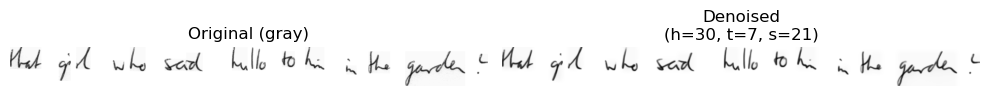

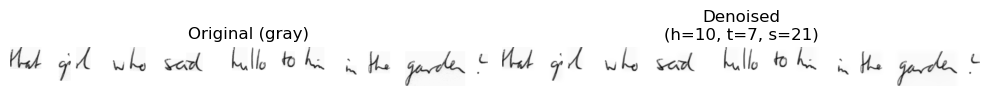

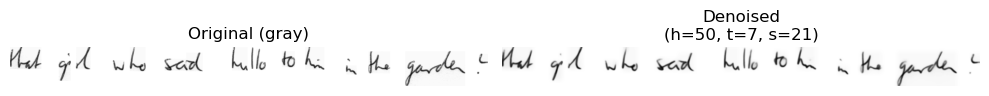

In [10]:
# Change this path to your image of choice:
path = "IAM_Data/images/r06-143-04.png"

# Try it with default params:
compare_fastnlmeans(path)

# Or tweak the strength/search window if you want more/less smoothing:
compare_fastnlmeans(path, h=10, templateWindowSize=7, searchWindowSize=21)
compare_fastnlmeans(path, h=50, templateWindowSize=7, searchWindowSize=21)


In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def compare_fastnlmeans_with_hist(image_path, h=30, templateWindowSize=7, searchWindowSize=21):
    """
    Load image, apply fastNlMeansDenoising, and show image + histogram comparison.
    """
    # Load and validate
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: could not load image at {image_path}")
        return

    # Resize (optional, for uniform viewing)
    # img = cv2.resize(img, (384, 384))

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply denoising
    denoised = cv2.fastNlMeansDenoising(gray, None, h, templateWindowSize, searchWindowSize)

    # Plot images and histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))

    # Original image
    axs[0, 0].imshow(gray, cmap='gray')
    axs[0, 0].set_title("Original (Grayscale)")
    axs[0, 0].axis('off')

    # Denoised image
    axs[0, 1].imshow(denoised, cmap='gray')
    axs[0, 1].set_title("Denoised (fastNlMeansDenoising)")
    axs[0, 1].axis('off')

    # Histogram of original
    axs[1, 0].hist(gray.ravel(), bins=256, color='gray', alpha=0.8)
    axs[1, 0].set_title("Histogram: Original")
    axs[1, 0].set_xlim([0, 255])

    # Histogram of denoised
    axs[1, 1].hist(denoised.ravel(), bins=256, color='blue', alpha=0.8)
    axs[1, 1].set_title("Histogram: Denoised")
    axs[1, 1].set_xlim([0, 255])

    plt.tight_layout()
    plt.show()


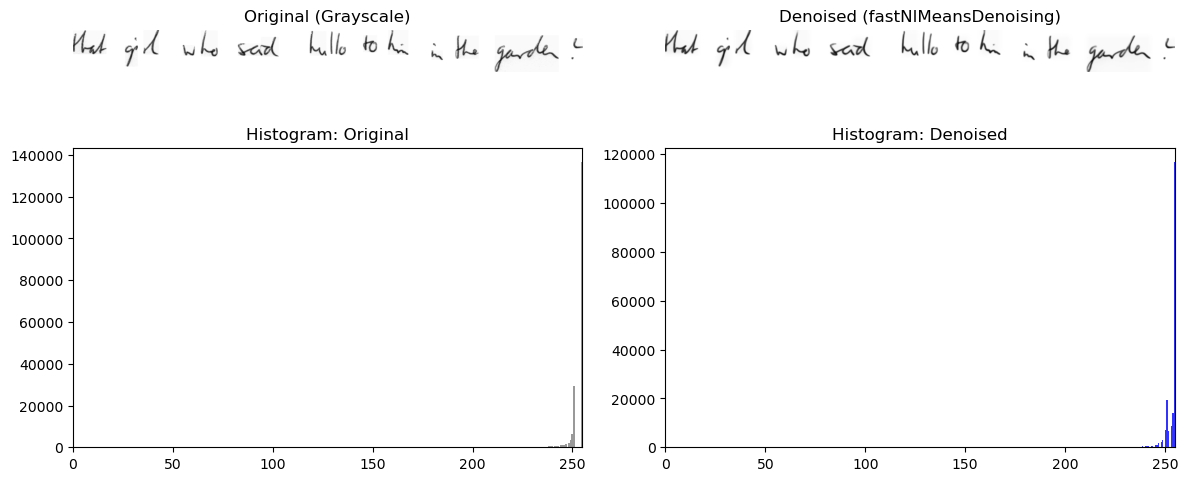

In [12]:
image_path = "IAM_Data/images/r06-143-04.png"
compare_fastnlmeans_with_hist(image_path)


### 📝 Selected Denoising Technique

Based on our exploration, I have chosen **Fast Non-Local Means Denoising** as the primary technique, as it effectively preserves fine details while reducing noise, making it particularly suitable for handwritten text recognition tasks.


### 🧠 Model Selection: Choosing the Right Architecture

For handwritten text recognition, we have selected **TrOCR** (Transformer-based OCR), a cutting-edge approach developed by Microsoft. It stands out for its exceptional performance in extracting text from complex handwritten documents.

#### 📌 Why TrOCR?
- **Architecture:** Combines a Vision Transformer (ViT) encoder with a text Transformer decoder.
- **Pretrained Model:** Available on Hugging Face as **microsoft/trocr-large-handwritten**, designed specifically for handwritten text.
- **Strengths:** High accuracy, strong contextual understanding, and robust handling of challenging handwritten inputs.

We will leverage this architecture for our final model implementation, ensuring our pipeline is optimized for real-world handwriting recognition.



### 📦 Installing Required Libraries

Before running the model, install the necessary packages:

```bash
!pip install transformers==4.45.1     # Transformers library for TrOCR model
!pip install evaluate                 # Evaluation framework
!pip install jiwer                   # Metrics for speech and text recognition
!pip install tf-keras                # TensorFlow Keras for model handling


In [13]:
!pip install transformers==4.45.1
!pip install evaluate
!pip install jiwer
!pip install tf-keras

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


**Importing Necessary Libraries**

In [14]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import torch
from torch.utils.data import Dataset
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)
import evaluate
import matplotlib.pyplot as plt

2025-05-16 09:23:57.944888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747367638.017798   14427 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747367638.038600   14427 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747367638.193074   14427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747367638.193095   14427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747367638.193097   14427 computation_placer.cc:177] computation placer alr

### 📁 Dataset Setup and Label Loading

Setting up with paths of `IAM_data/images`,  `IAM_data/Actual_Labels.csv`

In [15]:
# Paths
base_dir = "IAM_Data"  # Replace with your actual dataset path
images_dir = os.path.join(base_dir, "images")
labels_csv = os.path.join(base_dir, "Actual_Labels.csv")

df = pd.read_csv(labels_csv)
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(images_dir, os.path.basename(x)))

### 🛠️ Key Steps in Preprocessing

`Convert input image to grayscale.`

`Apply fastNlMeansDenoising for noise reduction.`

`Resize image to 384×384 while preserving aspect ratio.`

`Add white padding to maintain dimensions without distortion.`

`Convert final preprocessed image to RGB format for model input.`


In [16]:
def resize_with_padding(image, size=(384, 384)):
    old_size = image.shape[:2]  # (height, width)
    ratio = min(size[0] / old_size[0], size[1] / old_size[1])
    new_size = tuple([int(x * ratio) for x in old_size])
    resized_image = cv2.resize(image, (new_size[1], new_size[0]))
    delta_w = size[1] - new_size[1]
    delta_h = size[0] - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    color = 255  # White padding for grayscale
    new_img = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_img

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
    denoised = cv2.fastNlMeansDenoising(img, h=10)
    resized_with_padding = resize_with_padding(denoised)
    return Image.fromarray(resized_with_padding).convert("RGB")

### 📚 Custom Dataset Class: `IAMDataset`

- Initializes with a dataframe containing image paths and corresponding text labels, along with the TrOCR processor.
- Implements `__len__` to return dataset size.
- Implements `__getitem__` to:
  - Load and preprocess images using the defined preprocessing pipeline.
  - Tokenize images and text labels with the TrOCR processor, applying padding and truncation.
  - Return pixel values and encoded labels as tensors ready for model training.

---

###  Model and Processor Initialization

- Uses the pretrained **TrOCR large handwritten model** (`microsoft/trocr-large-handwritten`) from Hugging Face.
- Loads both the `TrOCRProcessor` for input processing and the `VisionEncoderDecoderModel` for sequence-to-sequence OCR.


In [17]:
class IAMDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'image_path']
        text = self.df.loc[idx, 'text']
        image = preprocess_image(image_path)
        inputs = self.processor(images=image, text=text, padding="max_length", return_tensors="pt", truncation=True)
        return {
            "pixel_values": inputs.pixel_values.squeeze(),
            "labels": inputs.labels.squeeze()
        }

# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model archite

In [18]:
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.use_cache = False
model.gradient_checkpointing_enable()

### 🔄 Dataset Splitting and Preparation

- The dataframe is shuffled randomly with a fixed seed (`random_state=42`) to ensure reproducibility.
- The data is split into three subsets:
  - **Training set:** 80% of the data.
  - **Validation set:** Next 10% for tuning and evaluation during training.
  - **Test set:** Final 10% for assessing model performance.
- Each subset is wrapped into the custom `IAMDataset` class using the TrOCR processor, preparing it for model input.


In [19]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_end = int(0.8 * len(df))
val_end = int(0.9 * len(df))

train_dataset = IAMDataset(df.iloc[:train_end], processor)
val_dataset = IAMDataset(df.iloc[train_end:val_end], processor)
test_dataset = IAMDataset(df.iloc[val_end:], processor)

### 📊 Evaluation Metrics Setup

- Loaded two key metrics from the `evaluate` library:
  - **CER (Character Error Rate):** Measures character-level errors between predicted and reference texts.
  - **WER (Word Error Rate):** Measures word-level errors, commonly used in speech and text recognition.

- Defined a `compute_metrics` function that:
  - Decodes model predictions and true labels into text strings.
  - Calculates CER and WER by comparing decoded predictions against references.
  - Returns the computed error rates for model evaluation during training and testing.


In [20]:
cer = evaluate.load("cer")
wer = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    return {
        "cer": cer.compute(predictions=pred_str, references=label_str),
        "wer": wer.compute(predictions=pred_str, references=label_str),
    }


### 🔑 Key Training Parameters

- `output_dir`: Directory to save model checkpoints and outputs.
- `per_device_train_batch_size` & `per_device_eval_batch_size`: Batch sizes for training and evaluation.
- `learning_rate`: Step size for optimizer updates (5e-5).
- `num_train_epochs`: Number of training epochs (10).
- `eval_strategy` & `save_strategy`: Evaluation and checkpoint saving frequency (per epoch).
- `fp16`: Enables mixed precision for faster and memory-efficient training.
- `gradient_checkpointing`: Saves memory by trading off compute during backpropagation.
- `load_best_model_at_end`: Automatically loads the best checkpoint after training.
- `logging_steps`: Interval for logging training progress (every 50 steps).
- `dataloader_num_workers`: Number of CPU workers for data loading (6).


In [21]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr_finetuned_iam",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=50,
    fp16=True,
    gradient_checkpointing=True,
    dataloader_num_workers=6,
    load_best_model_at_end=True,
    report_to="none"
)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator
)


### 🚀 Training, Evaluation, and Saving the Model

- `trainer.train()` starts the fine-tuning process on the training data.
- After training, the model is evaluated on the **test dataset** to measure performance using CER and WER.
- Evaluation results (CER and WER) are printed for quick assessment.
- Finally, the fine-tuned model and processor are saved to the specified output directory for later use or deployment.


In [22]:
trainer.train()

print("Evaluating on test set...")
results = trainer.evaluate(eval_dataset=test_dataset)
print("Test CER:", results["eval_cer"])
print("Test WER:", results["eval_wer"])

output_path = "./trocr_finetuned_model"
model.save_pretrained(output_path)
processor.save_pretrained(output_path)

[2025-05-16 09:26:22,304] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)
/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)
/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)
/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named argu

Epoch,Training Loss,Validation Loss,Cer,Wer
1,0.029000,0.014579,0.104073,0.196709
2,0.010700,0.011806,0.086347,0.161497
3,0.006800,0.010674,0.071072,0.143261
4,0.003700,0.010339,0.067498,0.134458
5,0.002100,0.009728,0.065295,0.131629
6,0.001300,0.008987,0.057938,0.121358
7,0.000800,0.008591,0.053346,0.113184
8,0.000500,0.007844,0.050623,0.106896
9,0.000200,0.007361,0.043017,0.094739
10,0.000100,0.006994,0.041126,0.091071


/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)
/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)
/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)
/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named argu

Evaluating on test set...


/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)
/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)
/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)
/home/nvlabs/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named argu

Test CER: 0.041042424735226554
Test WER: 0.0853398354160317


[]

### 🔍 Model Inference and Text Prediction

- **Loading Fine-Tuned Model:**  
  - Loads the saved TrOCR processor and model from the fine-tuned checkpoint.

- **Preprocessing Pipeline:**  
  - Grayscale conversion, denoising, resizing with padding, and RGB conversion for compatibility with the model.

- **Prediction Flow:**  
  - Processes the image into tensor inputs.  
  - Runs the model in **no gradient** mode for fast inference.  
  - Decodes the generated IDs to human-readable text.

- **Visualization:**  
  - Displays the input image alongside the predicted text using Matplotlib.


2025-05-16 14:39:53.433314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747386593.452930  552465 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747386593.458987  552465 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747386593.477315  552465 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747386593.477342  552465 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747386593.477344  552465 computation_placer.cc:177] computation placer alr

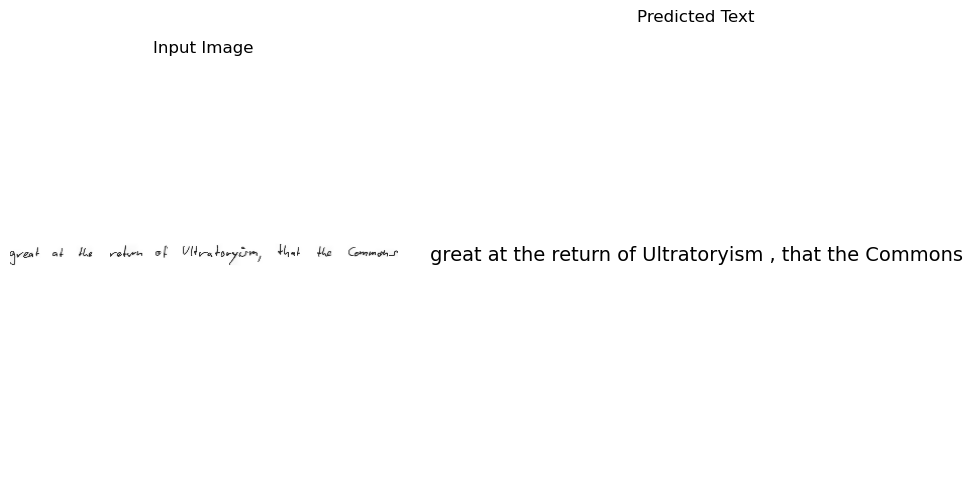

In [2]:
from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import cv2
import matplotlib.pyplot as plt

# Load the fine-tuned model and processor
model_path = "./trocr_finetuned_model"
processor = TrOCRProcessor.from_pretrained(model_path)
model = VisionEncoderDecoderModel.from_pretrained(model_path)

def resize_with_padding(image, size=(384, 384)):
    old_size = image.shape[:2]
    ratio = min(size[0] / old_size[0], size[1] / old_size[1])
    new_size = tuple([int(x * ratio) for x in old_size])
    resized_image = cv2.resize(image, (new_size[1], new_size[0]))
    delta_w = size[1] - new_size[1]
    delta_h = size[0] - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    color = 255  # White padding for grayscale
    new_img = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_img

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    denoised = cv2.fastNlMeansDenoising(img, h=10)
    resized_with_padding = resize_with_padding(denoised)
    return Image.fromarray(resized_with_padding).convert("RGB")

def predict_text(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)

    # Prepare the inputs for the model
    inputs = processor(images=image, return_tensors="pt").to(model.device)

    # Generate the predicted text
    with torch.no_grad():
        generated_ids = model.generate(**inputs)

    # Decode the generated ids to text
    predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return image, predicted_text

# Test on a single image
test_image_path = "test/g06-031i-04.png"
image, predicted_text = predict_text(test_image_path)

# Show the image and prediction side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.text(0.5, 0.5, predicted_text, ha='center', va='center', wrap=True, fontsize=14)
plt.title("Predicted Text")
plt.axis("off")

plt.tight_layout()
plt.show()


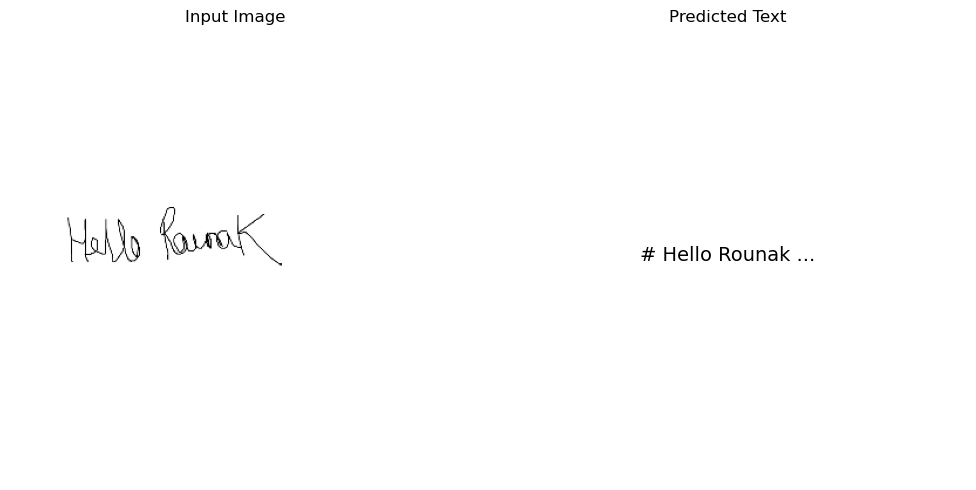

In [3]:
# Test on a single image
test_image_path = "test/t1.png"
image, predicted_text = predict_text(test_image_path)

# Show the image and prediction side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.text(0.5, 0.5, predicted_text, ha='center', va='center', wrap=True, fontsize=14)
plt.title("Predicted Text")
plt.axis("off")

plt.tight_layout()
plt.show()

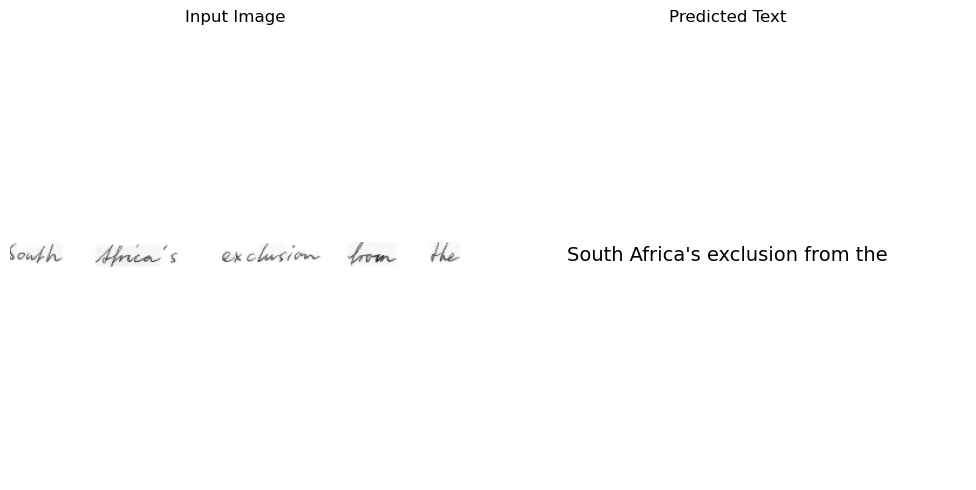

In [4]:
# Test on a single image
test_image_path = "test/b01-000-05.png"
image, predicted_text = predict_text(test_image_path)

# Show the image and prediction side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.text(0.5, 0.5, predicted_text, ha='center', va='center', wrap=True, fontsize=14)
plt.title("Predicted Text")
plt.axis("off")

plt.tight_layout()
plt.show()

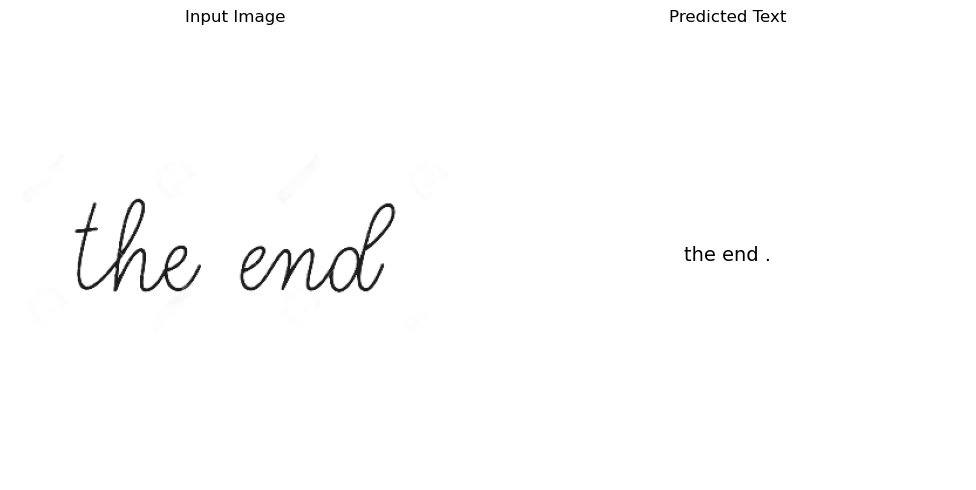

In [6]:
# Test on a single image
test_image_path = "test/t3.jpg"
image, predicted_text = predict_text(test_image_path)

# Show the image and prediction side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.text(0.5, 0.5, predicted_text, ha='center', va='center', wrap=True, fontsize=14)
plt.title("Predicted Text")
plt.axis("off")

plt.tight_layout()
plt.show()